In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

### Загружаем исходные данные

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обработки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_label

array([1., 0., 1., ..., 7., 6., 9.])

### Визуализируем исходные данные

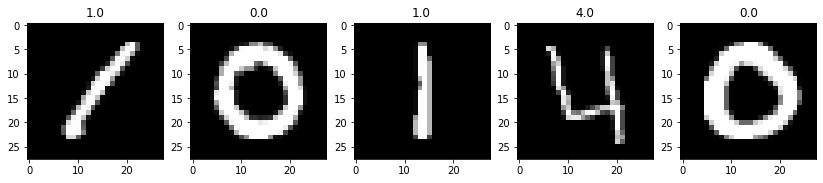

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray')
    subplot.set_title('%s' % train_label[i - 1])

### Визуализируем исходные данные и HOG

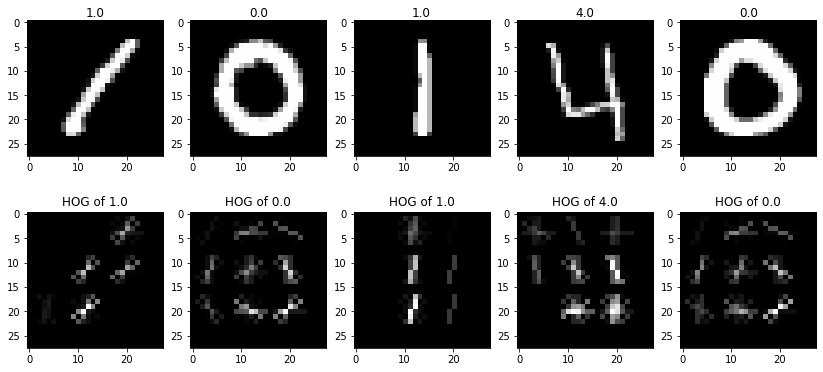

In [6]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot1 = fig.add_subplot(3, 7, i)
    plt.imshow(img, cmap='gray')
    subplot1.set_title(train_label[i - 1], pad = 1)
    
    hog_temp = hog(img, visualize = True)
    subplot2 = fig.add_subplot(1,7,i)
    plt.imshow(hog_temp[1], cmap = 'gray')
    subplot2.set_title(f'HOG of {train_label[i - 1]}')    

### Преобразуем каждую картинку в вектор HOG

In [7]:
hog_features = []
for image in train_img:
    fd = hog(image, feature_vector=True)
    hog_features.append(fd)

In [8]:
hog_features = np.array(hog_features)

In [9]:
X_test, x_train, y_test, y_train = train_test_split(hog_features, train_label, train_size = 0.8, random_state = 11)

### Воспользуемся классификатором на методе опорных векторов

In [10]:
classificator1 = svm.SVC(verbose = True)
classificator1.fit(X_test, y_test)

[LibSVM]

SVC(verbose=True)

In [11]:
classificator1.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': True}

In [12]:
classificator1.score(x_train, y_train)

0.9728571428571429

#### Результат 0.97 точность при использовании классификатора на основе метода опорных векторов и HOG. Вероятнее всего результат можно увеличить за счет тонкого подбора параметров при HOG (в частности ppc), а также подбора параметров модели.

### Сделаем классификацию на основе PCA преобразования и линейного классификатора

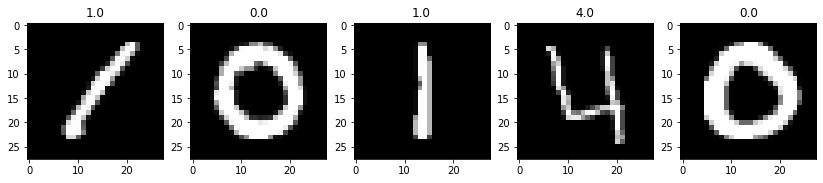

In [13]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray')
    subplot.set_title('%s' % train_label[i - 1])

In [14]:
X = train_img.reshape(-1, 28*28).astype(np.float32)

In [15]:
# центрируем данные
X_mean = X.mean(axis=0)
X -= X_mean

In [16]:
# матрица ковариации признаков
cov = np.dot(X.T, X) / X.shape[0]

In [17]:
# U - собсвенные вектора матрицы ковариации
# S - собственные значения
U, S, _ = np.linalg.svd(cov)

#### Собственные числа

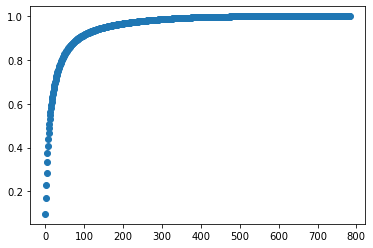

In [18]:
# накопленная сумма собственных значений
S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, 'o')

In [19]:
S_thr = 0.75  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=32 S=0.751


In [20]:
# получаем сжатое представление объектов
Xrot_reduced = np.dot(X, U[:, :n_comp])

In [21]:
Xrot_restored = np.dot(Xrot_reduced, U[:,:n_comp].T)

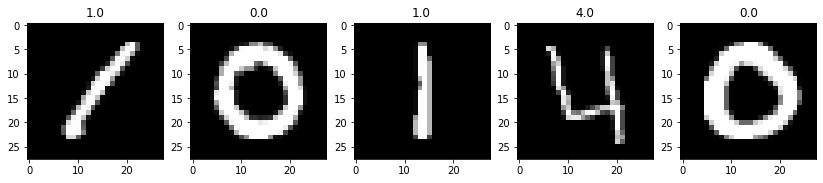

In [22]:
#оригиналы
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(X[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    img_ = img + X_mean
    plt.title('%s' % train_label[i - 1])
    plt.imshow(img_.reshape((28,28)), cmap='gray');

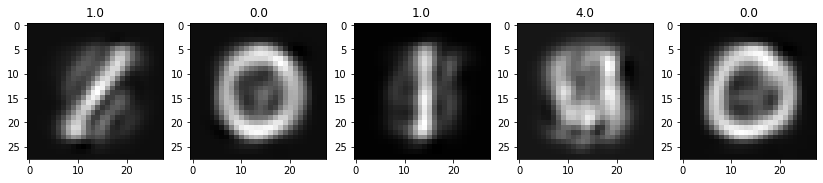

In [23]:
#восстановленные изображения
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(Xrot_restored[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    img_ = img + X_mean
    plt.title('%s' % train_label[i - 1])
    plt.imshow(img_.reshape((28,28)) + X_mean.reshape((28,28)), cmap='gray');

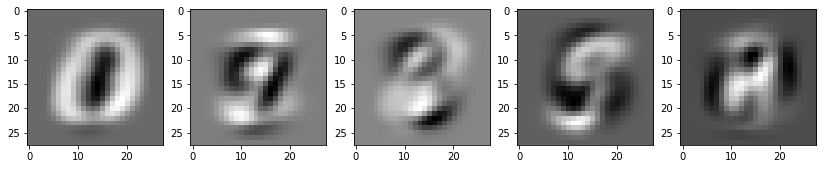

In [24]:
#собственные вектора
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(U.T[:5,:], 1):
    subplot = fig.add_subplot(1, 7, i)
    #plt.title('%s' % train_label[i - 1])
    plt.imshow(img.reshape((28,28)), cmap='gray');

In [25]:
X_test, x_train, y_test, y_train = train_test_split(Xrot_restored, train_label, train_size = 0.8, random_state = 11)

In [26]:
classificator2 = LogisticRegression(max_iter = 10000)
classificator2.fit(X_test, y_test)

LogisticRegression(max_iter=10000)

In [27]:
classificator2.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 10000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [28]:
classificator2.score(x_train, y_train)

0.8975

### Использование PCA вместе с линейным классификатором дало результат практически на 8 процентов меньше чем HOG + SVM. Возможно, что при использовании PCA в качестве признака для классификаии необходимо использование другого классификатора